# Step 2: HQNO Dose-Response Fitting Hybrid

This notebook performs dose-response analysis for HQNO experiments, combining FACS and microfluidics data to perform a Hill curve fitting with low-range spline interpolation.

**What this code does:**
1. **Data Integration**: Loads pre-processed FACS and microscopy calibration data (output from `1a_calibrate_facs_microscope_hqno.ipynb`)
2. **Data Preparation**: Combines microscopy and FACS data for fitting
3. **Hybrid Model Fitting**: Fits combined model consisting of:
   - Monotonic PCHIP spline on log₁₀(concentration) for accurate capture of low-dose responses
   - Hill function for the typical sigmoidal dose-response over full range
   - Combined fit, consisting of piecewise combination of PCHIP spline for [HQNO] <=SPLINE_CUTOFF and Hill for [HQNO] > SPLINE_CUTOFF
4. **Model Validation**: Calculates AIC and BIC metrics for model assessment
5. **Output Generation**: Saves calibration parameters, fitted curve plots, and processed data

Response curve is fitted to background corrected fluorescent intensities in microscopy units. FACS intensities where converted to microscopy intensities in notebook 1. Here background is subtracted using mode of control distribution

In [23]:
import json
from dataclasses import dataclass, asdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from pathlib import Path
from scipy.interpolate import PchipInterpolator


# ——— Configuration ———
MICRO_CSV = Path.cwd().parent / 'datafiles' / 'hqno_calibration_microscopy.csv'
FACSCONVERTED_CSV = Path.cwd() / 'data' / '1_hqno_facs_transformed.csv'
BACKGROUND_JSON = Path.cwd() / 'data' / 'background_intensities.json'
OUTPUT_JSON = Path.cwd() / 'data' / '2_hqno_calibration_curve_hybrid.json'

HQNO_ORDER = [
    'HQNO_0','HQNO_5','HQNO_10','HQNO_20','HQNO_40','HQNO_80',
    'HQNO_160','HQNO_320','HQNO_640','HQNO_1280','HQNO_2500','HQNO_5000'
]

# Low-range spline cutoff (ng/ml)
SPLINE_CUTOFF = 160

# ——— Model definition ———
def hill_function(x, a, c, b):
    """Simple Hill function.

    Computes y = a * x**b / (c**b + x**b).

    Inputs:
        x: array-like or scalar concentration values
        a, c, b: Hill parameters (floats)
    Returns:
        y: same-shaped array or scalar of modelled response
    """
    return a * x**b / (c**b + x**b)


def fit_hill(df_sel: pd.DataFrame, resp_col: str):
    """Fit a Hill curve to data.

    Inputs:
        df_sel: DataFrame containing at least columns ['conc', resp_col]
        resp_col: name of response column (string)
    Returns:
        params: dict with keys 'a','c','b'
        aic: Akaike information criterion (float)
        bic: Bayesian information criterion (float)
    """
    x = df_sel['conc'].to_numpy(float)
    y = df_sel[resp_col].to_numpy(float)

    # Initial guesses (guard against degenerate cases)
    a0 = float(max(np.max(y), 1e-9))
    c0 = float(max(np.median(x[x>0]) if np.any(x>0) else 1.0, 1e-9))
    b0 = 1.0
    p0 = [a0, c0, b0]

    popt, _ = curve_fit(hill_function, x, y, p0=p0, bounds=(0, np.inf), maxfev=30000)
    a, c, b = popt

    # Metrics
    yhat = hill_function(x, a, c, b)
    ssr = float(np.sum((y - yhat)**2))
    n, k = x.size, 3
    sigma2 = ssr / max(n, 1)
    aic = n * np.log(max(sigma2, 1e-12)) + 2 * k
    bic = n * np.log(max(sigma2, 1e-12)) + k * np.log(max(n, 1))

    return {'a': float(a), 'c': float(c), 'b': float(b)}, aic, bic


def fit_low_range_pchip(df_sel: pd.DataFrame, resp_col: str, cutoff: float):
    """Return a PCHIP interpolator for the low-concentration region.

    Inputs:
        df_sel: DataFrame with columns ['conc', resp_col]
        resp_col: response column name
        cutoff: numeric cutoff (include points with 0 < conc <= cutoff)
    Returns:
        pchip: PchipInterpolator built on log10(conc)
        xlog_u: 1D array of unique log10(conc) knots
        y_u: 1D array of response values at knots
    """
    dlow = df_sel[(df_sel['conc'] > 0) & (df_sel['conc'] <= cutoff)].copy()
    if dlow.empty:
        raise ValueError(f"No points at 0 < conc <= cutoff={cutoff}. Lower the cutoff or include more data.")
    # Sort by concentration to get strictly increasing x for PCHIP
    dlow = dlow.sort_values('conc')
    x = dlow['conc'].to_numpy(float)
    y = dlow[resp_col].to_numpy(float)
    # log10 transform for smoother behavior across decades
    xlog = np.log10(x)
    # Deduplicate any identical xlog (rare but can happen)
    uniq, idx = np.unique(xlog, return_index=True)
    xlog_u = xlog[idx]
    y_u = y[idx]
    if len(xlog_u) < 2:
        raise ValueError("Not enough unique low-range x values to build a spline.")
    pchip = PchipInterpolator(xlog_u, y_u, extrapolate=False)
    # Return spline and the raw arrays so we can serialize in JSON
    return pchip, xlog_u, y_u


def evaluate_hybrid(x_eval, hill_params, pchip, cutoff):
    """Evaluate hybrid model: spline for x <= cutoff, Hill for x > cutoff.

    Inputs:
        x_eval: array-like concentration values (same units as cutoff)
        hill_params: dict with keys 'a','c','b'
        pchip: PchipInterpolator on log10(conc)
        cutoff: numeric cutoff separating spline and Hill regions
    Output:
        y: numpy array of evaluated responses
    Notes:
        - x=0 is handled by clamping to the leftmost spline knot
        - spline is not extrapolated beyond its knot domain
    """
    x_eval = np.asarray(x_eval, float)
    y = np.empty_like(x_eval, dtype=float)
    mask_low = x_eval <= cutoff
    # Spline where available (no extrapolation beyond its domain)
    if np.any(mask_low):
        xlow = x_eval[mask_low]
        with np.errstate(divide='ignore'):
            xlow_log = np.log10(xlow)
        y_low = pchip(xlow_log)
        if np.any(np.isnan(y_low)):
            dom_min, dom_max = pchip.x[0], pchip.x[-1]
            xclamped = np.clip(xlow_log, dom_min, dom_max)
            y_low = pchip(xclamped)
        y[mask_low] = y_low
    # Hill elsewhere
    if np.any(~mask_low):
        a, c, b = hill_params['a'], hill_params['c'], hill_params['b']
        y[~mask_low] = hill_function(x_eval[~mask_low], a, c, b)
    return y


def parse_hqno_conc(label: str) -> float:
    """Parse HQNO label to numeric concentration.

    Example: 'HQNO_640' -> 640.0 ; 'HQNO_0' -> 0.0
    Input: label string
    Output: float concentration (ng/ml)
    """
    num = label.replace('HQNO_', '')
    return float(num)


def summarize_replicate_data(df_all_replicates: pd.DataFrame, ) -> pd.DataFrame:
    """Aggregate replicate-level data into summary statistics per source & concentration.

    Inputs:
        df_all_replicates: DataFrame with columns ['HQNO','Source','conc','gfp','excluded']
    Returns:
        agg: DataFrame with columns ['HQNO','Source','conc','excluded','gfp_median',
                                     'gfp_p25','gfp_p75','n_replicates',
                                     'gfp_err_low','gfp_err_high']
    """
    agg = (
        df_all_replicates
        .groupby(['HQNO', 'Source', 'conc', 'excluded'], observed=True)
        .agg(
            gfp_median=('gfp', 'median'),
            gfp_p25=('gfp', lambda s: np.percentile(s, 25)),
            gfp_p75=('gfp', lambda s: np.percentile(s, 75)),
            n_replicates=('gfp', 'count')
        )
        .reset_index()
    )
    
    # Calculate error bounds for plotting
    agg['gfp_err_low'] = agg['gfp_median'] - agg['gfp_p25']
    agg['gfp_err_high'] = agg['gfp_p75'] - agg['gfp_median']
    
    return agg


@ dataclass
class Calibration:
    method: str                       # 'hill+lowrange_spline'
    params: dict                      # Hill params
    AIC: float
    BIC: float
    y0: float                         # single global baseline shift for Hill plotting/eval
    response_col: str
    sources_used: list
    spline_cutoff: float
    spline_kind: str                  # 'pchip'
    spline_xlog10: list               # to reconstruct the spline
    spline_y: list

    def evaluate(self, x: np.ndarray) -> np.ndarray:
        """Evaluate the hybrid calibration for input concentrations x.

        Inputs:
            x: array-like concentrations
        Returns:
            array-like responses using stored spline and Hill params
        """
        pchip = PchipInterpolator(np.array(self.spline_xlog10, float),
                                  np.array(self.spline_y, float),
                                  extrapolate=False)
        return evaluate_hybrid(np.asarray(x, float), self.params, pchip, self.spline_cutoff)
    

# Advanced customizable plotting function
def plot_concentrations(df_all, 
                                     source_colors=None, 
                                     source_markers=None,
                                     source_sizes=None,
                                     figsize=(10, 6),
                                     linewidth=2,
                                     font_size=8,
                                     legend=True):
    """Plot dose-response summary points with inclusion/exclusion styling.

    Inputs:
        df_all: DataFrame with summary columns including 'conc','gfp_median','gfp_err_low','gfp_err_high','Source','excluded'
        source_colors: dict mapping source->color
        source_markers: dict mapping source->marker
        source_sizes: dict mapping source->marker size
    Returns:
        matplotlib Axes object
    """
    
    # Default colors and markers
    if source_colors is None:
        source_colors = {
            'Microscopy': 'tab:orange',
            'FACS (estimated)': 'tab:blue'
        }
    
    if source_markers is None:
        source_markers = {
            'Microscopy': 'o',
            'FACS (estimated)': 's'
        }

    if source_sizes is None:
        source_sizes = {
            'Microscopy': 6,
            'FACS (estimated)': 6
        }    
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot data by source and exclusion status
    for source in df_all['Source'].unique():
        source_data = df_all[df_all['Source'] == source]
        
        base_color = source_colors.get(source, 'tab:gray')
        marker = source_markers.get(source, 'o')
        size = source_sizes.get(source, 6)
        
        # Plot included data (filled symbols, full opacity)
        included_data = source_data[~source_data['excluded']]
        if len(included_data) > 0:
            plt.errorbar(
                included_data['conc'], 
                included_data['gfp_median'],
                yerr=[included_data['gfp_err_low'], included_data['gfp_err_high']],
                fmt=marker,
                color=base_color,
                markerfacecolor=base_color,
                markeredgecolor=base_color,
                label=f'{source} (included)',
                alpha=0.8,
                capsize=3,
                markersize=size,
                linewidth=linewidth
            )
        
        # Plot excluded data (open symbols, reduced opacity)
        excluded_data = source_data[source_data['excluded']]
        if len(excluded_data) > 0:
            plt.errorbar(
                excluded_data['conc'], 
                excluded_data['gfp_median'],
                yerr=[excluded_data['gfp_err_low'], excluded_data['gfp_err_high']],
                fmt=marker,
                color=base_color,
                markerfacecolor='none',
                markeredgecolor=base_color,
                label=f'{source} (excluded)',
                alpha=0.4,
                capsize=2,
                markersize=size,
                linestyle=None,
                linewidth=linewidth
            )

    plt.xscale('log')
    plt.xlabel('HQNO Concentration [ng/mL]', fontsize=font_size)
    plt.ylabel('Corrected GFP Intensity [a.u.]', fontsize=font_size)
    ax.tick_params(labelsize=font_size-1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, alpha=0.3)

    if legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt.gca()


def plot_dose_response_function(df_included, params, pchip, cutoff, styles, final_width_in=3, final_height_in=3, font_size=10):
    """Plot hybrid dose-response model with data, Hill function, spline, and combined fit.

    Inputs:
        df_included: DataFrame of included median points (columns: 'conc','Source','gfp')
        params: dict with Hill params {'a','c','b'}
        pchip: PchipInterpolator for low-range on log10(conc)
        cutoff: numeric cutoff for spline/Hill transition
        styles: dict of plot style kwargs for keys 'Hill','Spline','Combined'
    Returns:
        ax: matplotlib Axes with the plotted model and data
    """
    # Extract data
    x_data = df_included['conc'].to_numpy(float)

    # Generate fit data
    min_xval = 1 if x_data.min() <= 0 else x_data.min()
    x_fit = np.logspace(np.log10(min_xval), np.log10(x_data.max()), 200)
    y_fit = hill_function(x_fit, params['a'], params['c'], params['b'])

    # Create figure
    fig, ax = plt.subplots(figsize=(final_width_in, final_height_in))

    # Plot data points
    teal_color = 'grey'
    source_label_map = {
        'FACS (estimated)': 'FACS',
        'Microscopy': 'Microscopy'
    }

    y_min = df_included['gfp'].min()
    for src, sub in df_included.groupby('Source'):
        clean_label = source_label_map.get(src, src)
        if src == 'Microscopy':
            ax.scatter(sub['conc'], sub['gfp'] - y_min, 
                      s=30, label=clean_label, color=teal_color, 
                      marker='o', edgecolors='none', alpha=0.8)
        elif src == 'FACS (estimated)':
            ax.scatter(sub['conc'], sub['gfp'] - y_min, 
                      s=30, label=clean_label, facecolors='none', 
                      edgecolors=teal_color, marker='o', linewidths=0.75, alpha=0.8)
    # Plot hybrid
    y_fit_hybrid = evaluate_hybrid(x_fit, params, pchip, cutoff)
    ax.plot(x_fit, y_fit_hybrid, **styles['Combined'])

    # Plot Hill fit
    ax.plot(x_fit, y_fit, **styles['Hill'])

    # Plot low-range spline
    x_low_plot = np.logspace(np.log10(min_xval), np.log10(cutoff), 200)
    y_low_plot = pchip(np.log10(x_low_plot))
    ax.plot(x_low_plot, y_low_plot, **styles['Spline'])

    # Configure axes
    ax.set_xscale('log')
    ax.set_xlabel('HQNO [ng/mL]', fontsize=font_size)
    ax.set_ylabel('Corrected GFP Intensity [a.u.]', fontsize=font_size)
    ax.tick_params(labelsize=font_size-1)
    ax.set_xlim(1, 10000)
    ax.set_ylim(-200, 4000)

    # Clean up spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add legend
    ax.legend(fontsize=font_size-1, frameon=False, loc='center left')

    # Add parameter text box
    textstr = f'EC₅₀ = {params["c"]:.0f} ng, Hill coef. = {params["b"]:.2f}'
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, 
            fontsize=font_size-1, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, 
                     edgecolor='gray', linewidth=0.5))

    ax.grid(True, alpha=0.3)
    plt.tight_layout()

    return ax

In [24]:
# ——— Data loading and processing ———
# Load raw microscopy data
micro = pd.read_csv(MICRO_CSV) # Load microscopy data
micro['HQNO'] = (micro['HQNO']
                 .str.replace('_ng','', regex=False)
                 .astype(pd.CategoricalDtype(HQNO_ORDER, ordered=True)))

# Load converted FACS data (output of 1a_calibrate_facs_microscope_hqno.ipynb)
facs_converted = pd.read_csv(FACSCONVERTED_CSV) 
facs_converted['HQNO'] = pd.Categorical(facs_converted['HQNO'], categories=HQNO_ORDER, ordered=True)

# Load background values
with open(BACKGROUND_JSON, 'r') as f:
    background_values = json.load(f)
bg_value = background_values['HQNO']['bg_value']

# Compute microscopy medians over cells per chamber (to get per-replicate values)
micro_pos = (micro
             .groupby(['HQNO','pos'], observed=True)['intensity_raw_gfp']
             .median()
             .reset_index(name='gfp'))

micro_pos['conc'] = micro_pos['HQNO'].apply(parse_hqno_conc).astype(float)
micro_pos['Source'] = 'Microscopy'

# Prepare FACS data (already at per-replicate level)
facs_converted['conc'] = facs_converted['HQNO'].apply(parse_hqno_conc).astype(float)
facs_converted_prep = facs_converted.rename(columns={'predicted_micro_gfp':'gfp'})
facs_converted_prep['Source'] = 'FACS (estimated)'

# Combine all replicate-level data first
df_all_replicates = pd.concat([
    micro_pos[['HQNO', 'gfp', 'conc', 'Source']], 
    facs_converted_prep[['HQNO', 'gfp', 'conc', 'Source']]
], ignore_index=True)

df_all_replicates['HQNO'] = pd.Categorical(df_all_replicates['HQNO'], categories=HQNO_ORDER, ordered=True)

# perform background correction using HQNO=0 microscopy baseline
df_all_replicates['gfp'] = df_all_replicates['gfp'] - bg_value

# Add excluded column based on concentration criteria
# Microscopy: exclude if conc >= 40 or conc <= 0 (preferably use FACS data in this range)
# FACS: exclude if conc < 40 (below limit of detection) or conc > 2500 (growth inhibition)
df_all_replicates['excluded'] = False
df_all_replicates.loc[
    (df_all_replicates['Source'] == 'Microscopy') & 
    ((df_all_replicates['conc'] >= 40) ), 
    'excluded'
] = True
df_all_replicates.loc[
    (df_all_replicates['Source'] == 'FACS (estimated)') & 
    ((df_all_replicates['conc'] < 40) | (df_all_replicates['conc'] > 2500)), 
    'excluded'
] = True

# Now calculate summary statistics (median, p25, p75) over replicates separately for each source
df_all = summarize_replicate_data(df_all_replicates)

# Create included subset for fitting (keeping original variable name for compatibility)
# Use the median values for fitting
df_included = df_all[~df_all['excluded']].copy()
df_included = df_included.rename(columns={'gfp_median': 'gfp'})

# ——— Hill curve fitting ———
params, aic, bic = fit_hill(df_included, 'gfp')

# ——— Spline fitting ———
pchip, xlog_u, y_u = fit_low_range_pchip(df_included, 'gfp', cutoff=SPLINE_CUTOFF)

# Package results for downstream use / reproducibility
cal = Calibration(
    method='hill+lowrange_spline',
    params=params,
    AIC=aic,
    BIC=bic,
    y0 = bg_value,
    response_col='gfp',
    sources_used=sorted(df_included['Source'].unique()),
    spline_cutoff=SPLINE_CUTOFF,
    spline_kind='pchip',
    spline_xlog10=[float(v) for v in xlog_u],
    spline_y=[float(v) for v in y_u],
)

# Save JSON
with open(OUTPUT_JSON, 'w') as f:
    json.dump(asdict(cal), f, indent=2)

# Console summary
n_zero_all = int((df_all['conc'] == 0).sum())
n_zero_sel = int((df_included['conc'] == 0).sum())
print(f"Response column: gfp")
print(f"Sources used (pooled): {cal.sources_used}")
print(f"Global baseline shift y0 = {bg_value:.3f}")
print(f"Hill params: a={params['a']:.3g}, c={params['c']:.3g}, b={params['b']:.3g}")
print(f"AIC = {aic:.1f}, BIC = {bic:.1f}")
print(f"Zeros in all data: {n_zero_all}; zeros in selected-for-fit: {n_zero_sel}")
print(f"Spline: kind={cal.spline_kind}, cutoff=≤{SPLINE_CUTOFF:g} ng/ml, knots={len(cal.spline_xlog10)}")

Response column: gfp
Sources used (pooled): ['FACS (estimated)', 'Microscopy']
Global baseline shift y0 = 161.330
Hill params: a=900, c=158, b=1.14
AIC = 71.6, BIC = 72.5
Zeros in all data: 2; zeros in selected-for-fit: 1
Spline: kind=pchip, cutoff=≤160 ng/ml, knots=5


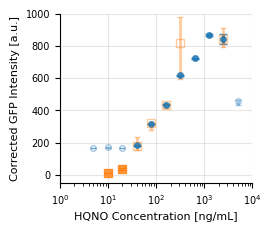

Filled symbols with darker colors: included data
Open symbols with lighter colors: excluded data
Error bars show 25th-75th percentile range across replicates
FACS data points are smaller circles, Microscopy data points are larger squares
For low HQNO values (<40 ng/mL), signal is below limit of detection of FACS


In [25]:
# ——— Figure styling ———
OUTPUT_PDF = Path.cwd() / 'figures' / 'hqno_facs_microfluidic_response_curve.pdf'
final_width_in = 7 / 2.54
final_height_in = 6 / 2.54
font_size = 8
plt.rcParams.update({
    'font.size': font_size,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

# Define colors and markers for each source
source_colors = {'Microscopy': 'tab:orange', 'FACS (estimated)': 'tab:blue'}
source_markers = {'Microscopy': 's', 'FACS (estimated)': 'o'}
source_size = {'Microscopy': 6,'FACS (estimated)': 4}

ax = plot_concentrations(df_all, 
                                     source_colors=source_colors, 
                                     source_markers=source_markers,
                                     source_sizes=source_size,
                                     figsize=(final_width_in, final_height_in),
                                     linewidth=2,
                                     font_size=font_size,
                                     legend=False)

plt.xlim(1, 10000)
plt.ylim(-50,1000)
plt.tight_layout()
plt.savefig(OUTPUT_PDF, dpi=300, transparent=True)
plt.show()

print("Filled symbols with darker colors: included data")
print("Open symbols with lighter colors: excluded data")
print("Error bars show 25th-75th percentile range across replicates")
print("FACS data points are smaller circles, Microscopy data points are larger squares")
print("For low HQNO values (<40 ng/mL), signal is below limit of detection of FACS")

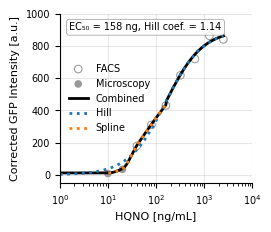

In [26]:
# ——— Figure styling ———
final_width_in = 7 / 2.54
final_height_in = 6 / 2.54
font_size = 8
plt.rcParams.update({
    'font.size': font_size,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

OUTPUT_PDF = Path.cwd() / 'figures' / 'hqno_fitted_dose_response_curve.pdf'

styles = {
    'Hill': {'lw': 2, 'linestyle': ':', 'color': "tab:blue", 'label': 'Hill'},
    'Spline' : {'lw': 2, 'linestyle': ':', 'color': "tab:orange", 'label': 'Spline'},
    'Combined': {'lw': 2, 'linestyle': '-', 'color': "black", 'label': 'Combined'}
}

ax = plot_dose_response_function(df_included, params, pchip, SPLINE_CUTOFF, styles,
                                 final_width_in=final_width_in, final_height_in=final_height_in,
                                 font_size=font_size)

plt.xlim(1, 10000)
plt.ylim(-50,1000)
plt.tight_layout()
plt.savefig(OUTPUT_PDF, dpi=300, transparent=True)
plt.show()